<a href="https://colab.research.google.com/github/raviintechis/A-Time-Series-Analysis-Corona-Death-Toll-Prediction/blob/main/A_Time_Series_Analysis_Corona_Death_Toll_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediciton of Corona Death Toll in Turkey

In this notebook, we will predict the number of patients dying due to coronavirus using simple Time Series prediction methods in Pyhthon's Pandas.

For this reason, we will use Turkey's daily reports from 13 March 2020 up to 1 May 2020

Let's begin with importing dependicies and data.


In [5]:
import pandas as pd
# prophet by Facebook
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt



## Load data

In [6]:
df = pd.read_csv('/content/corona.csv')
df.head()

,DAY,TESTS,POSITIVE,DEAD_TODAY,POSITIVE_RATIO,DEAD_POSITIVE_RATIO,DEAD_TOMORROW
0,14.3.2020,500,6,0,0.012000,0.000000,0.0
1,15.3.2020,845,12,0,0.014201,0.000000,0.0
2,16.3.2020,1000,29,0,0.029000,0.000000,1.0
3,17.3.2020,2000,51,1,0.025500,0.019608,1.0
4,18.3.2020,2500,93,1,0.037200,0.010753,2.0


## Select data

In [7]:
df= df[['DAY','DEAD_TODAY','DEAD_TOMORROW']].copy()
df.tail()

,DAY,DEAD_TODAY,DEAD_TOMORROW
44,27.4.2020,95,92.0
45,28.4.2020,92,89.0
46,29.4.2020,89,93.0
47,30.4.2020,93,84.0
48,1.5.2020,84,NaN


## Visualize the data in a plot.


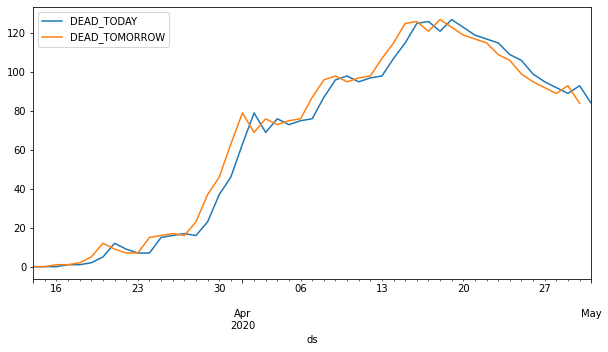

In [8]:
df['ds'] = pd.to_datetime(df['DAY'],  dayfirst = True)
df.plot(x='ds',   figsize=(10, 5))


# Prediction Method 1: Facebook's Prophet Model

As a prediction method, we will use Prophet. 

[More about Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) 




## Prepare data format for the Prophet Model

In [9]:
newdf = df[['ds', 'DEAD_TODAY']].copy()
df.drop(['ds'], axis=1, inplace=True)
newdf.rename(columns={'DEAD_TODAY': 'y'}, inplace=True)

newdf.tail()

,ds,y
44,2020-04-27,95
45,2020-04-28,92
46,2020-04-29,89
47,2020-04-30,93
48,2020-05-01,84


## Train & Predict

In [10]:
m = Prophet( )
m.fit(newdf)
horizon= 1
future = m.make_future_dataframe(periods=horizon)
forecast = m.predict(future)
forecast[['ds',  'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
45,2020-04-28,123.162907,96.844013,149.868437
46,2020-04-29,128.728895,102.965360,154.849148
47,2020-04-30,134.294940,108.300335,159.477075
48,2020-05-01,131.718296,106.878149,155.414203
49,2020-05-02,139.746378,112.838093,163.470922


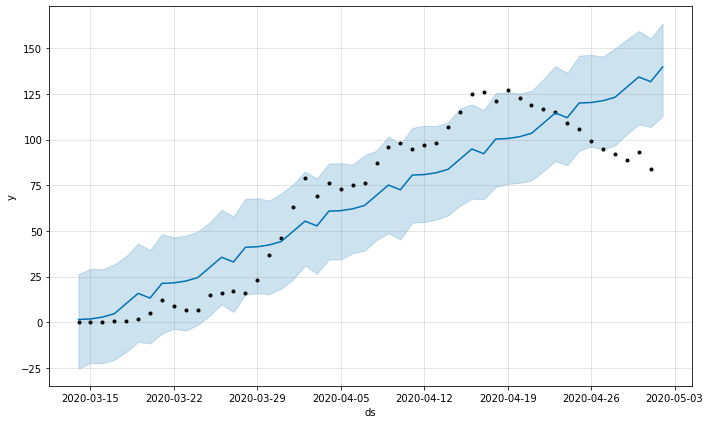

In [11]:
fig1 = m.plot(forecast)

In [12]:
#fig2 = m.plot_components(forecast)

## Record Mean Absolute Error 

In [13]:
MAE={}

MAE['Prophet'] =  mean_absolute_error(newdf['y'], forecast[:-horizon]['yhat'])

print("MAE : {}".format(MAE))

MAE : {'Prophet': 17.20520062349263}


## Compare the prediction with collected data 


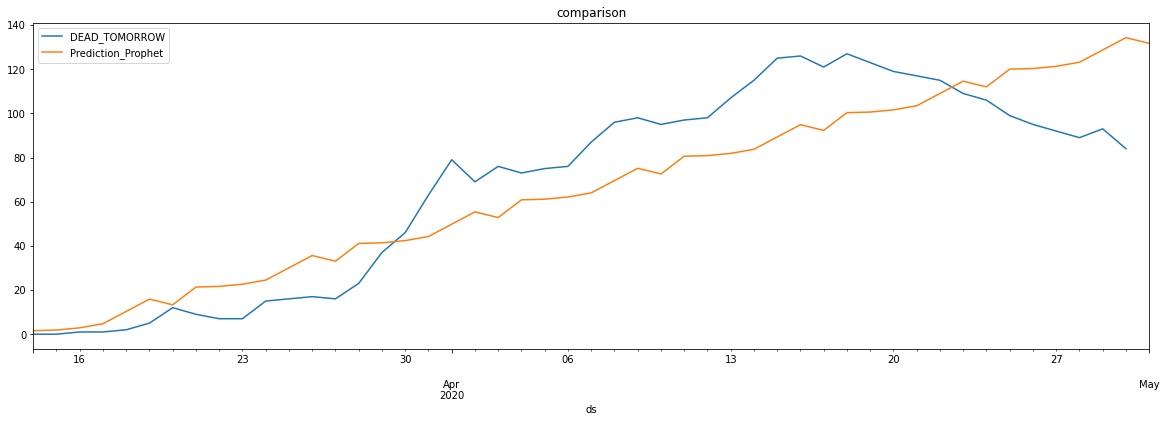

In [14]:
comparison= pd.DataFrame()
comparison['ds']=newdf['ds'].copy()
comparison['DEAD_TOMORROW']=df['DEAD_TOMORROW'].copy()
comparison['Prediction_Prophet'] = forecast[:-1].yhat
comparison.plot(title="comparison",x='ds',figsize=(20, 6))

# Prediction Method 2: Simple Moving Average (SMA)

Let's calculate Simple Moving Average with 3 days window


## Train & Predict

In [15]:
window= 3
df['Prediction_ SMA_3'] = df.iloc[:,1].rolling(window=window).mean()
df.head()

,DAY,DEAD_TODAY,DEAD_TOMORROW,Prediction_ SMA_3
0,14.3.2020,0,0.0,NaN
1,15.3.2020,0,0.0,NaN
2,16.3.2020,0,1.0,0.000000
3,17.3.2020,1,1.0,0.333333
4,18.3.2020,1,2.0,0.666667


## Record Mean Absolute Error 

In [16]:
MAE['SMA_3'] =  mean_absolute_error(df[2:-1]['DEAD_TOMORROW'], df[2:-1]['Prediction_ SMA_3'])
print("MAE : {}".format(MAE))

MAE : {'Prophet': 17.20520062349263, 'SMA_3': 7.369565217391303}


## Calculate the standard deviation & upper/lower bands


<Figure size 1440x432 with 0 Axes>

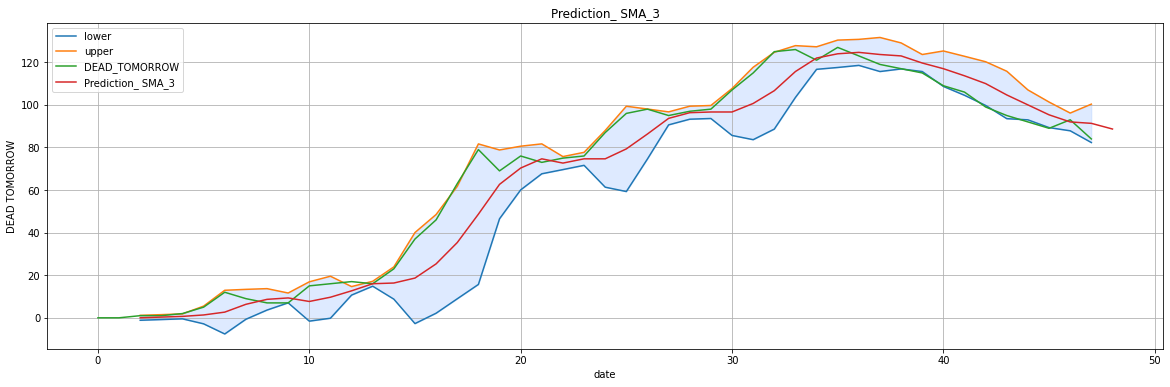

In [17]:
rstd = df.iloc[:,2].rolling(window=window).std()
bands = pd.DataFrame()
bands['DAY']= df['DAY'].copy()
bands['lower'] = df['Prediction_ SMA_3'] - 2 * rstd
bands['upper'] = df['Prediction_ SMA_3'] + 2 * rstd


bands = bands.join(df['DEAD_TOMORROW']).join(df['Prediction_ SMA_3'])
fig = plt.figure(figsize=(20, 6))
ax = bands.plot(title='Prediction_ SMA_3', figsize=(20, 6))
ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.4)
ax.set_xlabel('date')
ax.set_ylabel('DEAD TOMORROW')
ax.grid()

plt.show()

## Compare the prediction with collected data 

           ds  DEAD_TOMORROW  Prediction_Prophet  Prediction_SMA_3
44 2020-04-27           92.0          121.311069        100.000000
45 2020-04-28           89.0          123.162907         95.333333
46 2020-04-29           93.0          128.728895         92.000000
47 2020-04-30           84.0          134.294940         91.333333
48 2020-05-01            NaN          131.718296         88.666667


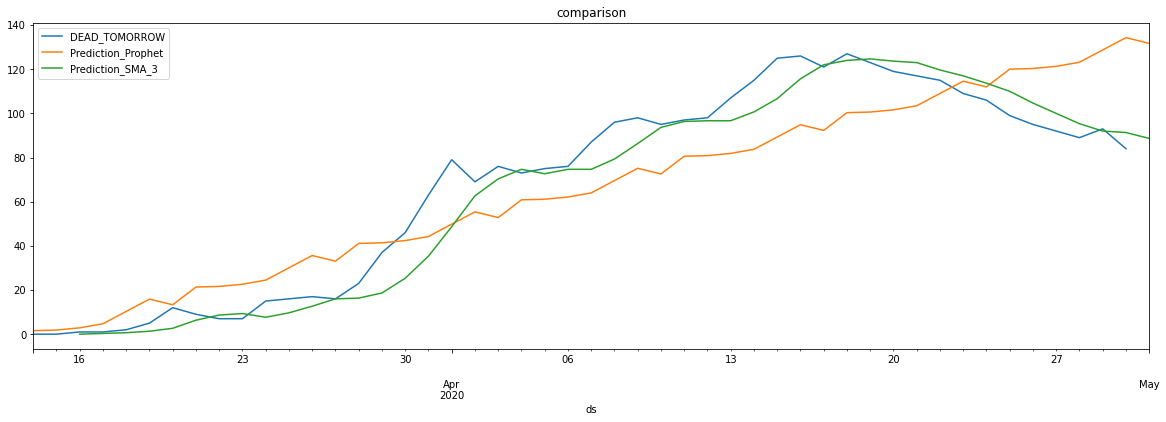

In [18]:
comparison['Prediction_SMA_3'] = df['Prediction_ SMA_3']
print(comparison.tail())
comparison.plot(title="comparison",x='ds',figsize=(20, 6))

# Prediction Method 3: Exponential Moving Average (EMA)

EMA(t)

EMA(t0)=(1−α)

EMA(t−1)+α p(t)=p(t0)
 
where p(t) is the price at time t and α is called the decay parameter for the EMA. 

α is related to the lag as
α=1/L+1

and the length of the window (span) M as
α=2/M+1.

The reason why EMA reduces the lag is that it puts more weight on more recent observations, whereas the SMA weights all observations equally by 1/M.


## Train & Predict

In [19]:
df['Prediction_EMA_3'] = df.iloc[:,1].ewm(span=window,adjust=False).mean()
df.head()


,DAY,DEAD_TODAY,DEAD_TOMORROW,Prediction_ SMA_3,Prediction_EMA_3
0,14.3.2020,0,0.0,NaN,0.00
1,15.3.2020,0,0.0,NaN,0.00
2,16.3.2020,0,1.0,0.000000,0.00
3,17.3.2020,1,1.0,0.333333,0.50
4,18.3.2020,1,2.0,0.666667,0.75


## Record Mean Absolute Error 

In [20]:
MAE['EMA_3'] =  mean_absolute_error(df[1:-1]['DEAD_TOMORROW'], df[1:-1]['Prediction_EMA_3'])
print("MAE : {}".format(MAE))

MAE : {'Prophet': 17.20520062349263, 'SMA_3': 7.369565217391303, 'EMA_3': 6.924589985225562}


## Calculate the standard deviation & upper/lower bands

<Figure size 1440x432 with 0 Axes>

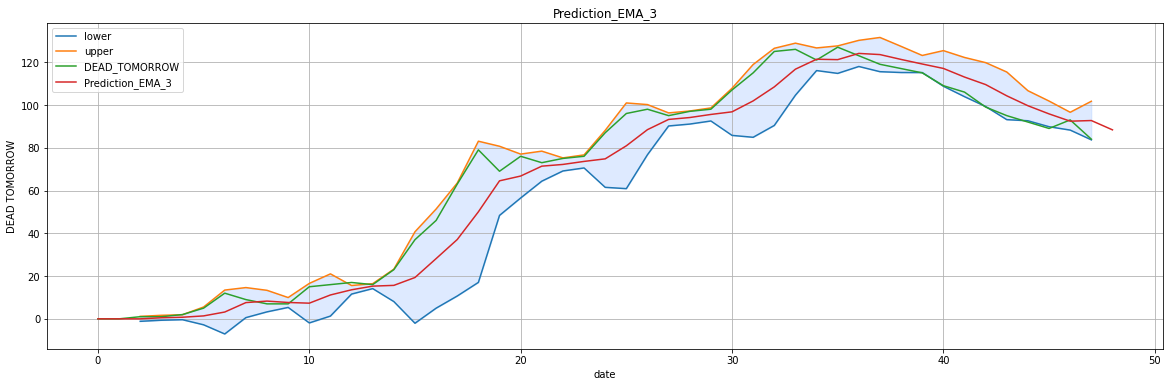

In [21]:
rstd = df.iloc[:,2].rolling(window=window).std()
bands = pd.DataFrame()
bands['DAY']= df['DAY'].copy()
bands['lower'] = df['Prediction_EMA_3'] - 2 * rstd
bands['upper'] = df['Prediction_EMA_3'] + 2 * rstd
bands = bands.join(df['DEAD_TOMORROW']).join(df['Prediction_EMA_3'])
fig = plt.figure(figsize=(20, 6))
ax = bands.plot(title='Prediction_EMA_3', figsize=(20, 6))
ax.fill_between(bands.index, bands['lower'], bands['upper'], color='#ADCCFF', alpha=0.4)
ax.set_xlabel('date')
ax.set_ylabel('DEAD TOMORROW')
ax.grid()
plt.show()

## Compare the prediction with collected data 

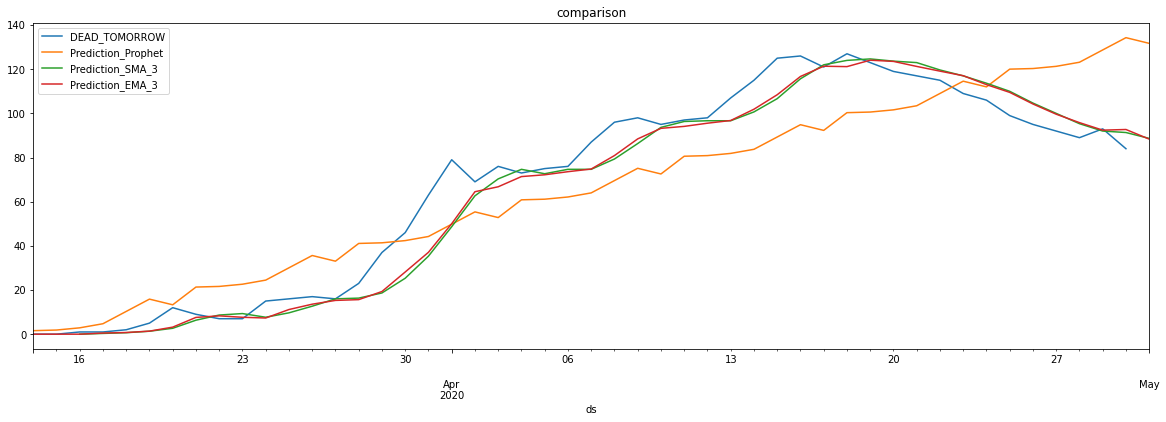

In [22]:
comparison['Prediction_EMA_3'] = df['Prediction_EMA_3']
comparison.plot(title="comparison",x='ds',figsize=(20, 6))

#Summary


In [23]:
print('Mean Absolute Errors (MAE): {}'.format(MAE))

Mean Absolute Errors (MAE): {'Prophet': 17.20520062349263, 'SMA_3': 7.369565217391303, 'EMA_3': 6.924589985225562}


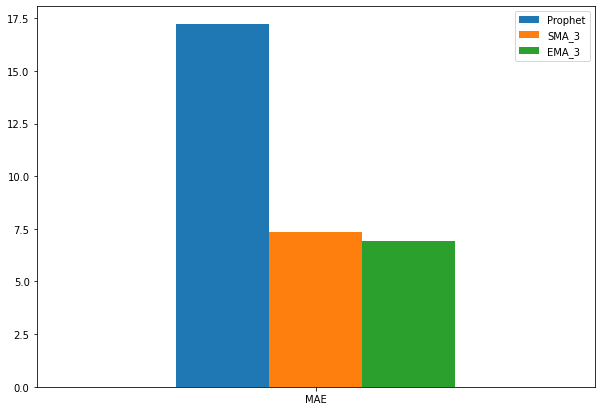

In [24]:
errorsDF = pd.DataFrame(MAE, index=['MAE']) 
ax = errorsDF.plot.bar(rot=0, figsize=(10, 7))

# Conclusion

Given the data set and using the Prophet SMA, EMA to forecast next day:
* Data has ONLY 48 days
* EMA has the lowest error
* The predicted loss for 02.05.2020 is -I hope and wish nobody dies- **88** by SMA & EMA
* However, we observe that DEAD TOMORROW ***mostly close to lower band***: thus we can update our prediction down to **80** ***assuming standard deviation is around 4***!  


In [25]:
rstd.tail()

44    3.511885
45    3.000000
46    2.081666
47    4.509250
48         NaN
Name: DEAD_TOMORROW, dtype: float64

In [26]:
bands.tail()

,DAY,lower,upper,DEAD_TOMORROW,Prediction_EMA_3
44,27.4.2020,92.605490,106.653028,92.0,99.629259
45,28.4.2020,89.814629,101.814629,89.0,95.814629
46,29.4.2020,88.243983,96.570647,93.0,92.407315
47,30.4.2020,83.685158,101.722157,84.0,92.703657
48,1.5.2020,NaN,NaN,NaN,88.351829
